# DistilBERT Fine-Tuning with PyTorch

This notebook is an example of how to fine-tune a DistilBERT model using PyTorch and the Hugging Face Transformers library to perform sentiment analysis on the amazon reviews dataset. The dataset is available [here](https://www.kaggle.com/datasets/tarkkaanko/amazon).

This version of the notebook uses the balanced training dataset, which contains a balanced number of 1,2,3,4 and 5 star reviews. The dataset is split into 55% training, 25% validation and 20% testing.

This results are discussed in the report.

In [1]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score
from matplotlib import pyplot as plt 

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Assicurati che le etichette siano interi e non one-hot, e sono scalari per ogni esempio.
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # dtype=torch.long per etichette di classificazione
        return item

class DistilBertModelBuilder:
    def __init__(self, num_labels, max_length=512):
        # Il tokenizer è definito come attributo della classe qui
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
        self.max_length = max_length
        self.trainer = None

    def train(self, X_train, y_train, X_val, y_val, epochs=3, batch_size=8):
        # Utilizzo del tokenizer definito nell'oggetto
        train_dataset = SentimentDataset(X_train, y_train, self.tokenizer, self.max_length)
        val_dataset = SentimentDataset(X_val, y_val, self.tokenizer, self.max_length)
        
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        self.trainer.train()

    def predict(self, X_test, y_test):
        test_dataset = SentimentDataset(X_test, y_test, self.tokenizer, self.max_length)
        predictions = self.trainer.predict(test_dataset)
        print(f"Predictions shape: {predictions.predictions.shape}")  # Dimensioni dell'output del modello
        print(f"Label shape: {predictions.label_ids.shape}")  # Dimensioni delle etichette
        y_pred = np.argmax(predictions.predictions, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f'F1 score: {f1:.2f}')
        print(f'Accuracy: {accuracy:.2f}')
        print(classification_report(y_test, y_pred)) 
        return y_pred

    def get_model(self):
        return self.model

In [3]:
# Gestione dei dati non bilanciati per confronto
from data import DataPreprocessor
unbalanced_data = DataPreprocessor('dataset/dataset_1/amazon_reviews.csv')
unbalanced_data.load_and_preprocess()
unbalanced_data.split_data()

X_train, X_val, X_test, y_train, y_val, y_test = unbalanced_data.get_train_val_test_data()


y_train = [int(label-1) for label in y_train]
y_val = [int(label-1) for label in y_val]
y_test = [int(label-1) for label in y_test]

X_train = [str(text) for text in X_train]
X_val = [str(text) for text in X_val]
X_test = [str(text) for text in X_test]

[nltk_data] Downloading package punkt to
[nltk_data]     /home/g.criscione2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/g.criscione2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/g.criscione2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data preprocessed successfully!
Preprocessing completed.
Data split completed.


In [4]:
model = DistilBertModelBuilder(num_labels=5)
model.train(X_train, y_train, X_val, y_val, epochs=3, batch_size=8)

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: d-bedini2 (bedo). Use `wandb login --relogin` to force relogin


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,1.599600
20,1.572800
30,1.507000
40,1.398400
50,1.244500
60,0.992000
70,0.889800
80,0.749800
90,0.667700
100,0.764500


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (1229, 5)
Label shape: (1229,)
F1 score: 0.75
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.38      0.82      0.52        61
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00       132
           4       0.86      0.96      0.91       981

    accuracy                           0.81      1229
   macro avg       0.25      0.36      0.29      1229
weighted avg       0.70      0.81      0.75      1229

              precision    recall  f1-score   support

    Negative       0.49      0.79      0.60        81
     Neutral       0.00      0.00      0.00        35
    Positive       0.97      0.95      0.96      1113

    accuracy                           0.91      1229
   macro avg       0.48      0.58      0.52      1229
weighted avg       0.91      0.91      0.91      1229



/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Predictions shape: (1229, 5)
Label shape: (1229,)
F1 score: 0.91
Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.49      0.79      0.60        81
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00         0
           4       0.97      0.95      0.96      1113

    accuracy                           0.91      1229
   macro avg       0.36      0.43      0.39      1229
weighted avg       0.91      0.91      0.91      1229



/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

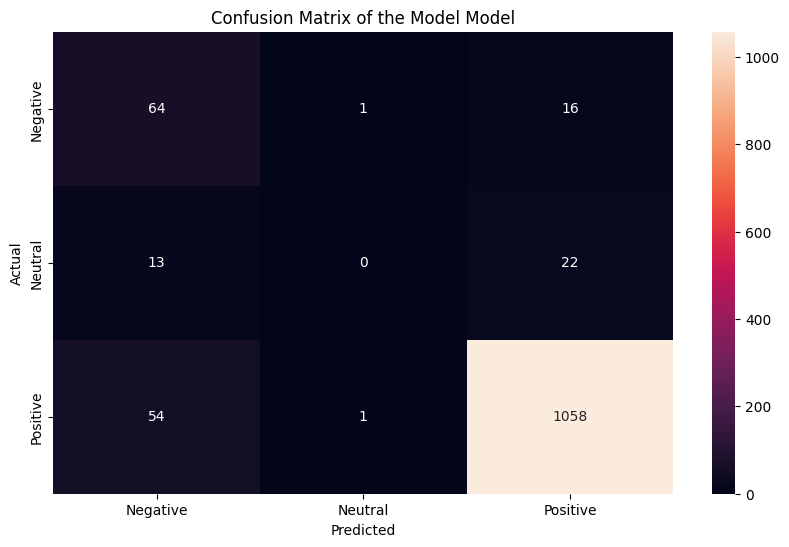

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Predictions shape: (1229, 5)
Label shape: (1229,)
F1 score: 0.75
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.38      0.82      0.52        61
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00       132
           4       0.86      0.96      0.91       981

    accuracy                           0.81      1229
   macro avg       0.25      0.36      0.29      1229
weighted avg       0.70      0.81      0.75      1229



/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

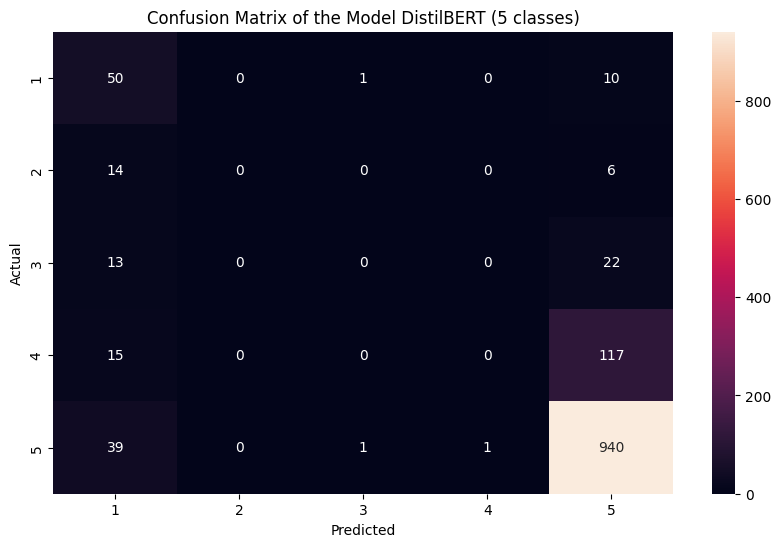

In [5]:
from utils import plot_confusion_matrix, metrics_with_three_classes

metrics_with_three_classes(model, X_test, y_test, "DistilBERT (3 classes)")
plot_confusion_matrix(model, X_test, y_test, "DistilBERT (5 classes)" )